## AIM: Final evaluation of Graph Convolutional Networks (GCNs) as multiclass classification models for predicting the psychiatric diagnosis based on EEG features

Final evaluation of the top 3 models during tuning for each feature set condition [EC, EO, ratio] and each GCN [graphlambda wo edge_attr, graphlambda with edge_attr]

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna

import lightning.pytorch as pl
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d
from torch_geometric.nn import  GCNConv, global_add_pool,GATConv,GINConv, GATv2Conv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx, to_networkx
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

### Load data & features

In [2]:
import pickle
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

In [3]:
# import stat & conn features without feature selection
df_stat_conn_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_stat_conn_features.pkl')
df_stat_conn_features = df_stat_conn_features.dropna(subset=['diagnosis'])

# label encode diagnosis
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_stat_conn_features['diagnosis'])
df_stat_conn_features['diagnosis'] = le.transform(df_stat_conn_features['diagnosis'])

print(df_stat_conn_features.shape)
df_stat_conn_features.sample(3)

(2700, 1218)


,ID,diagnosis,epoch,EO_l_frontal_delta_std,EO_l_frontal_delta_mean,EO_l_frontal_delta_median,EO_l_frontal_delta_skew,EO_l_frontal_delta_kurt,EO_l_frontal_theta_std,EO_l_frontal_theta_mean,...,ratio_gamma_m_central-r_central,ratio_gamma_m_central-l_posterior,ratio_gamma_m_central-m_posterior,ratio_gamma_m_central-r_posterior,ratio_gamma_r_central-l_posterior,ratio_gamma_r_central-m_posterior,ratio_gamma_r_central-r_posterior,ratio_gamma_l_posterior-m_posterior,ratio_gamma_l_posterior-r_posterior,ratio_gamma_m_posterior-r_posterior
856,sub-87982849,1,5,0.064086,0.097026,0.097026,1.191023,1.380935,0.040608,0.069809,...,0.992538,0.940187,0.963240,0.921592,0.930346,0.955460,0.947460,0.969238,0.934661,0.938622
240,sub-87968541,4,1,0.089510,0.101121,0.101121,2.049815,5.338304,0.038491,0.056343,...,1.000681,0.987383,0.985054,0.996881,1.001662,1.001205,1.014341,0.991114,0.998108,0.999344
229,sub-87968449,4,2,0.043221,0.068566,0.068566,1.232245,1.463289,0.023603,0.049516,...,1.004218,1.046749,1.048204,1.062283,1.058253,1.050578,1.025129,1.044515,1.073899,1.049093


In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_conn_features_ec = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EO') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_eo = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_ratio = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('EO'))]]
print(df_stat_conn_features_ratio.shape)
print(df_stat_conn_features_ec.shape)
print(df_stat_conn_features_eo.shape)

(2700, 408)
(2700, 408)
(2700, 408)


In [5]:
synchrony_feature_dict = load_file(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\synchrony_feature_dict.pkl')
subjects_ec_syncro_matrices = synchrony_feature_dict['EC_syncro']
subjects_eo_syncro_matrices = synchrony_feature_dict['EO_syncro']
subjects_ec_ids = synchrony_feature_dict['EC_IDs']
subjects_eo_ids = synchrony_feature_dict['EO_IDs']
print(len(subjects_ec_syncro_matrices), len(subjects_eo_syncro_matrices))
print(len(subjects_ec_ids), len(subjects_eo_ids))
print(subjects_ec_syncro_matrices[0].shape)
print(subjects_ec_ids[0])

224 225
224 225
(12, 5, 9, 9)
sub-87964717


In [6]:
# compute ratio [EC/EO] synchrony matrices

# Convert the lists to sets
subjects_ec_ids_set = set(subjects_ec_ids)
subjects_eo_ids_set = set(subjects_eo_ids)

# find the missing IDs to make sure ratio is computed within the same participant
missing_ids = subjects_eo_ids_set - subjects_ec_ids_set
missing_ids_indices = [subjects_eo_ids.index(id) for id in missing_ids]

# remove missing IDs from EO
ratio_subjects_eo_syncro_matrices = [matrix for i, matrix in enumerate(subjects_eo_syncro_matrices) if i not in missing_ids_indices]
assert len(ratio_subjects_eo_syncro_matrices) == len(subjects_ec_syncro_matrices)

# compute ratio
subjects_ratio_syncro_matrices = []
for i in range(len(subjects_ec_syncro_matrices)):
    ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]
    subjects_ratio_syncro_matrices.append(ratio_matrix)
subjects_ratio_ids = subjects_ec_ids
print(len(subjects_ratio_syncro_matrices), len(subjects_ratio_ids))

224 224


C:\Users\tuur\AppData\Local\Temp\ipykernel_24084\1473655494.py:18: RuntimeWarning: invalid value encountered in divide
  ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]


In [7]:
# define function to store features in PyTorch Geometric Data objects
import networkx as nx
from joblib import Parallel, delayed # for parallel processing
from tqdm import tqdm
def process_subject(syncros, subject_id, df_features):
    graph_dataset = []
    y_list = []

    # obtain statistical features for subject
    subject_stat_features = df_features[df_features['ID'] == subject_id]
    stat_columns = ['epoch', 'mean', 'median', 'std', 'skew', 'kurt'] # select statistical features
    pattern = '|'.join(stat_columns)  # create a pattern string
    subject_stat_features = subject_stat_features[subject_stat_features.columns[subject_stat_features.columns.str.contains(pattern)]]
    
    for epoch, syncro_matrices in enumerate(syncros):
        num_edges = int((syncro_matrices.shape[1] * (syncro_matrices.shape[2] - 1)) / 2)
        bands = syncro_matrices.shape[0]
        edge_attrs = np.zeros((num_edges, bands)) # create empty array to store edge weights for each frequency band

        for i, syncro_matrix in enumerate(syncro_matrices):
            # print(f'{syncro_matrix.shape = }')
            syncro_graph = nx.from_numpy_array(syncro_matrix)
            # print(f'{syncro_graph = }')
            edge_list = nx.to_pandas_edgelist(syncro_graph)
            edge_list = edge_list.dropna(axis=0)
            # print(f'{edge_list = }')
            edge_index = edge_list.iloc[:,0:2].values.T # shape (2, num_edges), edge_index stays the same for all bands right?
            # print(f'{edge_index = }')
            edge_attr = edge_list.iloc[:,2].values#.reshape(-1,1)
            edge_attrs[:,i] = edge_attr

        y = df_stat_conn_features_ec[df_stat_conn_features_ec['ID'] == subject_id]['diagnosis'].values[0]
        
        # store statistical features for subject
        ch_groups = ['l_frontal', 'm_frontal', 'r_frontal', 'l_central', 'm_central', 'r_central', 'l_posterior', 'm_posterior', 'r_posterior']
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        x = np.zeros((len(ch_groups), len(bands) * (len(stat_columns)-1))) # -1 because of epochs column in stat_columns
        # print(x.shape)
        for num, ch_group in enumerate(ch_groups):
            x[num] = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            

        data = Data(x=torch.tensor(x, dtype=torch.float),                     # Node features [num_nodes, num_node_features]
                    edge_index=torch.tensor(edge_index, dtype=torch.long),    # Adjacency matrix [2, num_edges]
                    edge_attr=torch.tensor(edge_attrs,dtype=torch.float),  # Edge features [num_edges, num_edge_features]
                    y=torch.tensor([y], dtype=torch.long))                    # Target/Label (it should be a list) --> torch.long for classification, torch.float for regression
        graph_dataset.append(data)
        y_list.append(y)

    return graph_dataset, y_list

In [8]:
# retrieve and store data for EC features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ec) for syncros, subject_id in tqdm(zip(subjects_ec_syncro_matrices, subjects_ec_ids), total=len(subjects_ec_syncro_matrices)))

ec_graph_dataset = []
ec_y_list = []
for result in results:
    ec_graph_dataset.extend(result[0])
    ec_y_list.extend(result[1])
    
assert len(ec_graph_dataset) == len(ec_y_list)

print(f'{ec_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ec_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ec_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ec_graph_dataset) = }, subjects: {len(subjects_ec_syncro_matrices)}, epochs: {len(subjects_ec_syncro_matrices[0])}')
print(f'{ec_graph_dataset[0] = }')

100%|██████████| 224/224 [00:24<00:00,  9.11it/s]


ec_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ec_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ec_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ec_graph_dataset) = 2688, subjects: 224, epochs: 12
ec_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [9]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_eo) for syncros, subject_id in tqdm(zip(subjects_eo_syncro_matrices, subjects_eo_ids), total=len(subjects_eo_syncro_matrices)))

eo_graph_dataset = []
eo_y_list = []
for result in results:
    eo_graph_dataset.extend(result[0])
    eo_y_list.extend(result[1])
    
assert len(eo_graph_dataset) == len(eo_y_list)

print(f'{eo_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{eo_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{eo_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(eo_graph_dataset) = }, subjects: {len(subjects_eo_syncro_matrices)}, epochs: {len(subjects_eo_syncro_matrices[0])}')
print(f'{eo_graph_dataset[0] = }')

100%|██████████| 225/225 [00:06<00:00, 32.93it/s]


eo_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
eo_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
eo_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(eo_graph_dataset) = 2700, subjects: 225, epochs: 12
eo_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [10]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ratio) for syncros, subject_id in tqdm(zip(subjects_ratio_syncro_matrices, subjects_ratio_ids), total=len(subjects_ratio_syncro_matrices)))

# process_subject(subjects_ratio_syncro_matrices[0], subjects_ratio_ids[0])

ratio_graph_dataset = []
ratio_y_list = []
for result in results:
    ratio_graph_dataset.extend(result[0])
    ratio_y_list.extend(result[1])
    
assert len(ratio_graph_dataset) == len(ratio_y_list)

print(f'{ratio_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ratio_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ratio_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ratio_graph_dataset) = }, subjects: {len(subjects_ratio_syncro_matrices)}, epochs: {len(subjects_ratio_syncro_matrices[0])}')
print(f'{ratio_graph_dataset[0] = }')

100%|██████████| 224/224 [00:07<00:00, 31.18it/s]


ratio_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ratio_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ratio_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ratio_graph_dataset) = 2688, subjects: 224, epochs: 12
ratio_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [11]:
# load the indices of the validation sets from the ML models
data_split_indices = load_file('data_split_indices.pkl')

# GCN models:

### Model: graphLambda without edge_attr

In [12]:
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import  GCNConv, global_add_pool, GATConv, GINConv


n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class graphLambda_wo_edge_attr(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, fc_layers, dropout):
        super(graphLambda_wo_edge_attr, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        #GCN-representation
        self.conv1 = GCNConv(n_features, 256, cached=False )
        self.bn01 = BatchNorm1d(256)
        self.conv2 = GCNConv(256, 128, cached=False )
        self.bn02 = BatchNorm1d(128)
        self.conv3 = GCNConv(128, 128, cached=False)
        self.bn03 = BatchNorm1d(128)
        #GAT-representation
        self.gat1 = GATConv(n_features, 256, heads=3)
        self.bn11 = BatchNorm1d(256*3)
        self.gat2 = GATConv(256*3, 128, heads=3)
        self.bn12 = BatchNorm1d(128*3)
        self.gat3 = GATConv(128*3, 128, heads=3)
        self.bn13 = BatchNorm1d(128*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(n_features, 256), ReLU(), Linear(256, 256))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(256)
        fc_gin2=Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(128)
        fc_gin3=Sequential(Linear(128, 64), ReLU(), Linear(64, 64))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(64)
        # Fully connected layers for concatinating outputs (varied depending on fc_layers)
        self.fcs = ModuleList()
        self.dropouts = ModuleList()
        input_size = 128*4 + 64 # Input size for the first layer
        output_size = num_classes # Output size for the last layer
        sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
        for i in range(fc_layers): # Create the layers
            self.fcs.append(Linear(sizes[i], sizes[i + 1]))
            self.dropouts.append(Dropout(p=dropout))

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        for fc, dropout in zip(self.fcs, self.dropouts):
            cr = F.relu(fc(cr))
            cr = dropout(cr)
        #cr = F.relu(cr).view(-1)
        cr = F.log_softmax(cr, dim=1) # Activation function for classification
        return cr  
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch.x, train_batch.y
        output = self.forward(train_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        output = self.forward(batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        return y_hat

### Model: graphLambda with edge_attr

In [13]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import  GCNConv, global_add_pool, GATConv, GINConv, GATv2Conv


n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC
n_edge_attrs = 5 # [Delta, Theta, Alpha, Beta, Gamma]

class graphLambda_w_edge_attr(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, fc_layers, dropout):
        super(graphLambda_w_edge_attr, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        #GCN-representation
        self.conv1 = GCNConv(n_features, 256, cached=False )
        self.bn01 = BatchNorm1d(256)
        self.conv2 = GCNConv(256, 128, cached=False )
        self.bn02 = BatchNorm1d(128)
        self.conv3 = GCNConv(128, 128, cached=False)
        self.bn03 = BatchNorm1d(128)
        #GAT-representation
        self.gat1 = GATv2Conv(n_features, 256, heads=3, edge_dim=n_edge_attrs)
        self.bn11 = BatchNorm1d(256*3)
        self.gat2 = GATv2Conv(256*3, 128, heads=3, edge_dim=n_edge_attrs)
        self.bn12 = BatchNorm1d(128*3)
        self.gat3 = GATv2Conv(128*3, 128, heads=3, edge_dim=n_edge_attrs)
        self.bn13 = BatchNorm1d(128*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(n_features, 256), ReLU(), Linear(256, 256))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(256)
        fc_gin2=Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(128)
        fc_gin3=Sequential(Linear(128, 64), ReLU(), Linear(64, 64))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(64)
        # Fully connected layers for concatinating outputs (varied depending on fc_layers)
        self.fcs = ModuleList()
        self.dropouts = ModuleList()
        input_size = 128*4 + 64 # Input size for the first layer
        output_size = num_classes # Output size for the last layer
        sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
        for i in range(fc_layers): # Create the layers
            self.fcs.append(Linear(sizes[i], sizes[i + 1]))
            self.dropouts.append(Dropout(p=dropout))

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index, edge_attr))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index, edge_attr))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index, edge_attr))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        for fc, dropout in zip(self.fcs, self.dropouts):
            cr = F.relu(fc(cr))
            cr = dropout(cr)
        #cr = F.relu(cr).view(-1)
        cr = F.log_softmax(cr, dim=1) # Activation function for classification
        return cr  
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch.x, train_batch.y
        output = self.forward(train_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        output = self.forward(batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        return y_hat

# 1. EC feature set

In [14]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EC'][0]
baseline_val_idxs = data_split_indices['EC'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ec_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ec_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ec_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ec_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ec_y_list[i] for i in baseline_rest_idxs]
Y_val = [ec_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ec_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


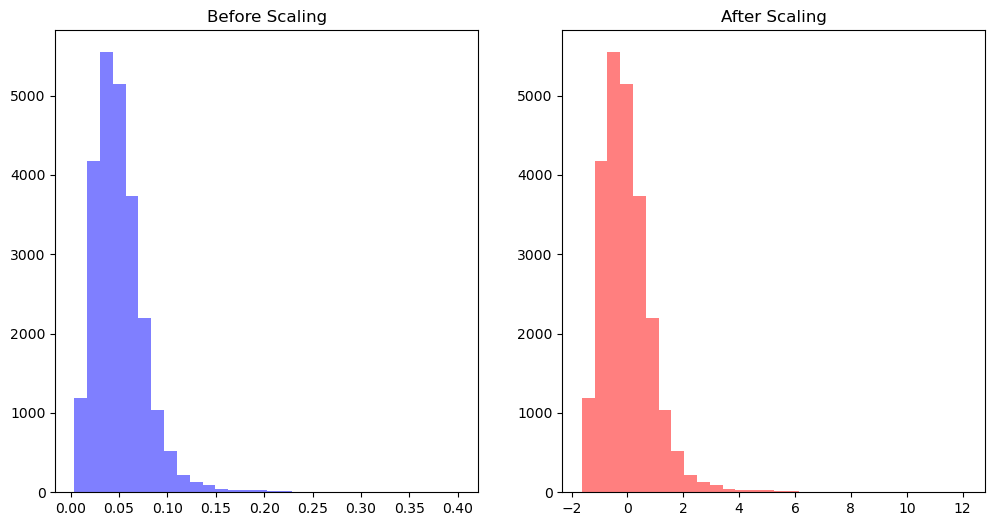

In [15]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val])) # fit on training and validation data


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: graphLambda without edge_attr

In [16]:
# import best trials from tuning
df_trials_wo_edge_attrs = pd.read_pickle('tuning_results\ec_results_wo_edge_attrs_trials.pkl')
df_trials_wo_edge_attrs = df_trials_wo_edge_attrs.sort_values('value', ascending=False).head(3)
df_trials_wo_edge_attrs

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_fc_layers,params_learning_rate,params_optimizer,state
11,11,0.335900,2024-06-04 15:38:47.394650,2024-06-04 15:43:21.113679,0 days 00:04:33.719029,510,0.306507,7,0.000130,Adam,COMPLETE
25,25,0.322751,2024-06-04 16:30:33.520746,2024-06-04 16:35:35.997939,0 days 00:05:02.477193,680,0.233819,1,0.000010,Adam,COMPLETE
53,53,0.320175,2024-06-04 18:39:52.920316,2024-06-04 18:45:00.390837,0 days 00:05:07.470521,680,0.273573,2,0.000016,Adam,COMPLETE


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #1 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.3232390880584717     │
│         val_loss          │     5.422239303588867     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.40      0.37      0.38       108
     HEALTHY       0.35      0.42      0.38       108
         MDD       0.31      0.29      0.30       108
         OCD       0.23      0.23      0.23       108
         SMC       0.33      0.31      0.32       108

    accuracy                           0.32       540
   macro avg       0.32      0.32      0.32       540
weighted avg       0.32      0.32      0.32       540



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #2 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.3124884366989136     │
│         val_loss          │     2.309211015701294     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.41      0.43      0.42       108
     HEALTHY       0.35      0.37      0.36       108
         MDD       0.33      0.31      0.32       108
         OCD       0.23      0.23      0.23       108
         SMC       0.24      0.23      0.23       108

    accuracy                           0.31       540
   macro avg       0.31      0.31      0.31       540
weighted avg       0.31      0.31      0.31       540



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #3 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │     0.317320317029953     │
│         val_loss          │     2.590172290802002     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.35      0.39      0.37       108
     HEALTHY       0.38      0.44      0.41       108
         MDD       0.33      0.29      0.31       108
         OCD       0.25      0.27      0.26       108
         SMC       0.27      0.22      0.24       108

    accuracy                           0.32       540
   macro avg       0.32      0.32      0.32       540
weighted avg       0.32      0.32      0.32       540

Mean f1-score 3 best trials: 0.3177
STD f1-score 3 best trials: 0.0044


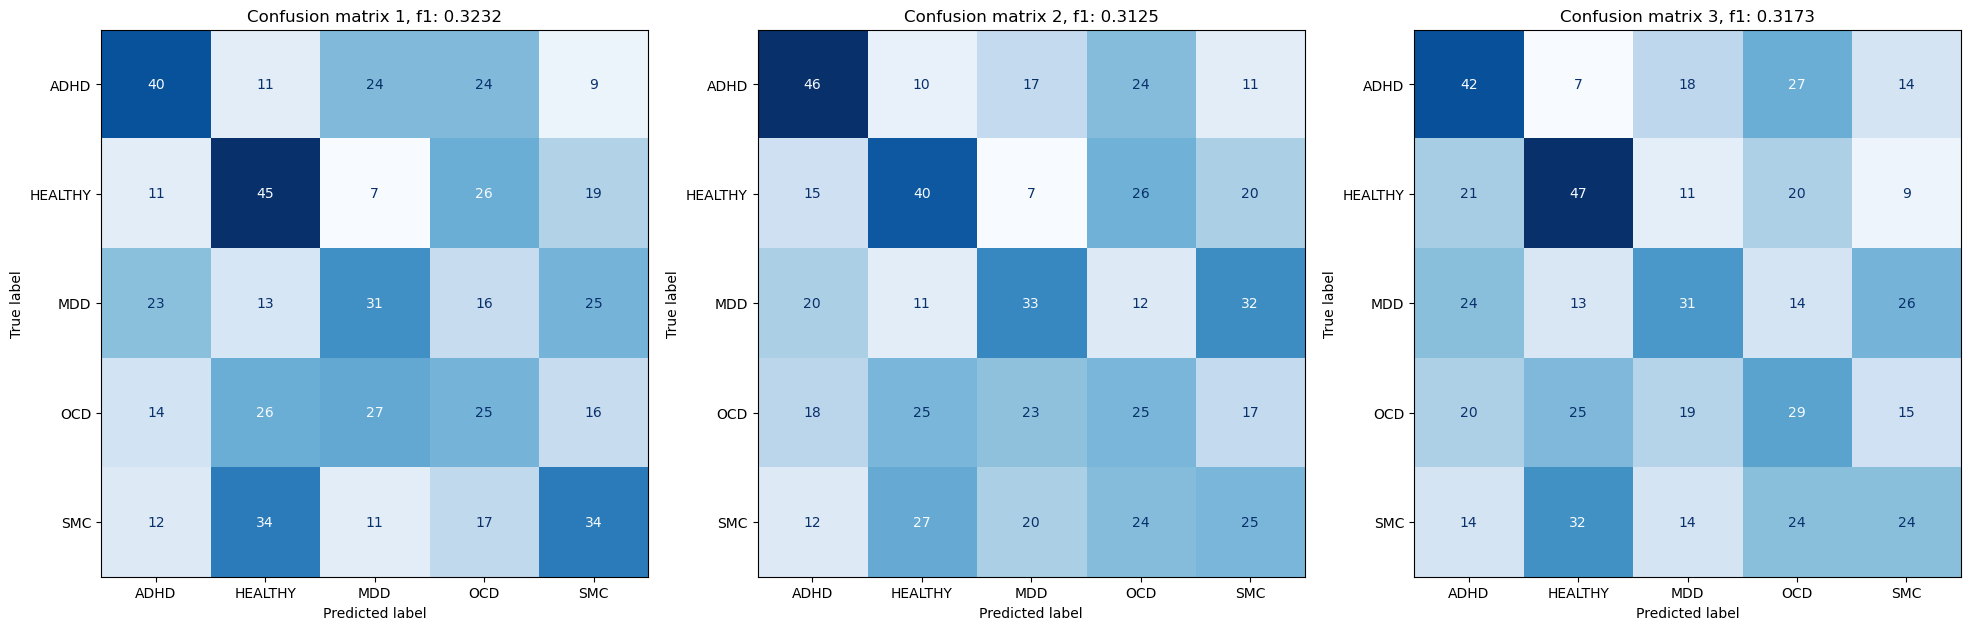

In [17]:
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar, ModelSummary
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import logging
import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

# create subplots for confusion matrices
fig, ax = plt.subplots(1, 3, figsize=(24, 16))

# list for storing f1-scores:
f1_scores = []

# iterate over the 3 best trials during tuning
for num, trial in enumerate(df_trials_wo_edge_attrs.iterrows()):
    # retrieve the hyperparameters
    learning_rate = trial[1]['params_learning_rate']
    optimizer_name = trial[1]['params_optimizer']
    fc_layers = trial[1]['params_fc_layers']
    dropout = trial[1]['params_dropout']
    batch_size = trial[1]['params_batch_size']

    # use best parameters from optuna
    model = graphLambda_wo_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)
    n_epochs = batch_size * 4

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                                drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                                drop_last=True) # , num_workers=0, persistent_workers=True


    checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                        mode='max',
                                        save_top_k=5,
                                        filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                        )


    trainer = Trainer(callbacks=[checkpoint_callback, ModelSummary(max_depth=0)],
                    accelerator='gpu',
                    max_epochs=n_epochs,
                    enable_progress_bar=False,
                    check_val_every_n_epoch=10,
                    log_every_n_steps=10,
                    deterministic=False,
                    )

    trainer.fit(model, train_loader, val_loader)

    print()
    print(f'Final evaluation #{num+1} trial:')
    # get evaluation of best model checkpoint
    trainer.validate(model, val_loader, ckpt_path='best')

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, val_loader, ckpt_path='best')
    y_pred = np.concatenate(y_pred).flatten()
    y = Y_val

    class_labels = le.inverse_transform(sorted(np.unique(y)))
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    f1_scores.append(f1_score(y, y_pred, average="macro"))

    # plot confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax[num])
    ax[num].set_title(f'Confusion matrix {num+1}, f1: {f1_score(y, y_pred, average="macro"):.4f}')
print(f'Mean f1-score 3 best trials: {np.mean(f1_scores):.4f}')
print(f'STD f1-score 3 best trials: {np.std(f1_scores):.4f}')

### Model: graphLambda with edge_attr

In [18]:
# import best trials from tuning
df_trials_w_edge_attrs = pd.read_pickle('tuning_results\ec_results_w_edge_attrs_trials.pkl')
df_trials_w_edge_attrs = df_trials_w_edge_attrs.sort_values('value', ascending=False).head(3)
df_trials_w_edge_attrs

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_fc_layers,params_learning_rate,params_optimizer,state
24,24,0.351992,2024-06-05 00:00:58.384045,2024-06-05 00:04:00.951588,0 days 00:03:02.567543,170,0.299775,6,0.001454,Adam,COMPLETE
75,75,0.341787,2024-06-05 03:09:29.278275,2024-06-05 03:15:45.543977,0 days 00:06:16.265702,680,0.442808,7,0.000966,Adam,COMPLETE
26,26,0.337003,2024-06-05 00:04:28.299002,2024-06-05 00:07:26.898730,0 days 00:02:58.599728,170,0.007451,6,0.001398,Adam,COMPLETE



Final evaluation #1 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.14827871322631836    │
│         val_loss          │    1.7486146688461304     │
└───────────────────────────┴───────────────────────────┘

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


classification report:
               precision    recall  f1-score   support

        ADHD       0.22      0.86      0.35       108
     HEALTHY       0.00      0.00      0.00       108
         MDD       0.00      0.00      0.00       108
         OCD       0.00      0.00      0.00       108
         SMC       0.38      0.41      0.39       108

    accuracy                           0.25       540
   macro avg       0.12      0.25      0.15       540
weighted avg       0.12      0.25      0.15       540



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #2 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.29906678199768066    │
│         val_loss          │     5.993618965148926     │
└───────────────────────────┴───────────────────────────┘

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


classification report:
               precision    recall  f1-score   support

        ADHD       0.30      0.63      0.41       108
     HEALTHY       0.39      0.41      0.40       108
         MDD       0.00      0.00      0.00       108
         OCD       0.34      0.31      0.32       108
         SMC       0.37      0.36      0.37       108

    accuracy                           0.34       540
   macro avg       0.28      0.34      0.30       540
weighted avg       0.28      0.34      0.30       540


Final evaluation #3 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.33903050422668457    │
│         val_loss          │    4.7935895919799805     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.43      0.44      0.44       108
     HEALTHY       0.38      0.41      0.39       108
         MDD       0.29      0.31      0.30       108
         OCD       0.25      0.22      0.24       108
         SMC       0.34      0.32      0.33       108

    accuracy                           0.34       540
   macro avg       0.34      0.34      0.34       540
weighted avg       0.34      0.34      0.34       540

Mean f1-score 3 best trials: 0.2621
STD f1-score 3 best trials: 0.0821


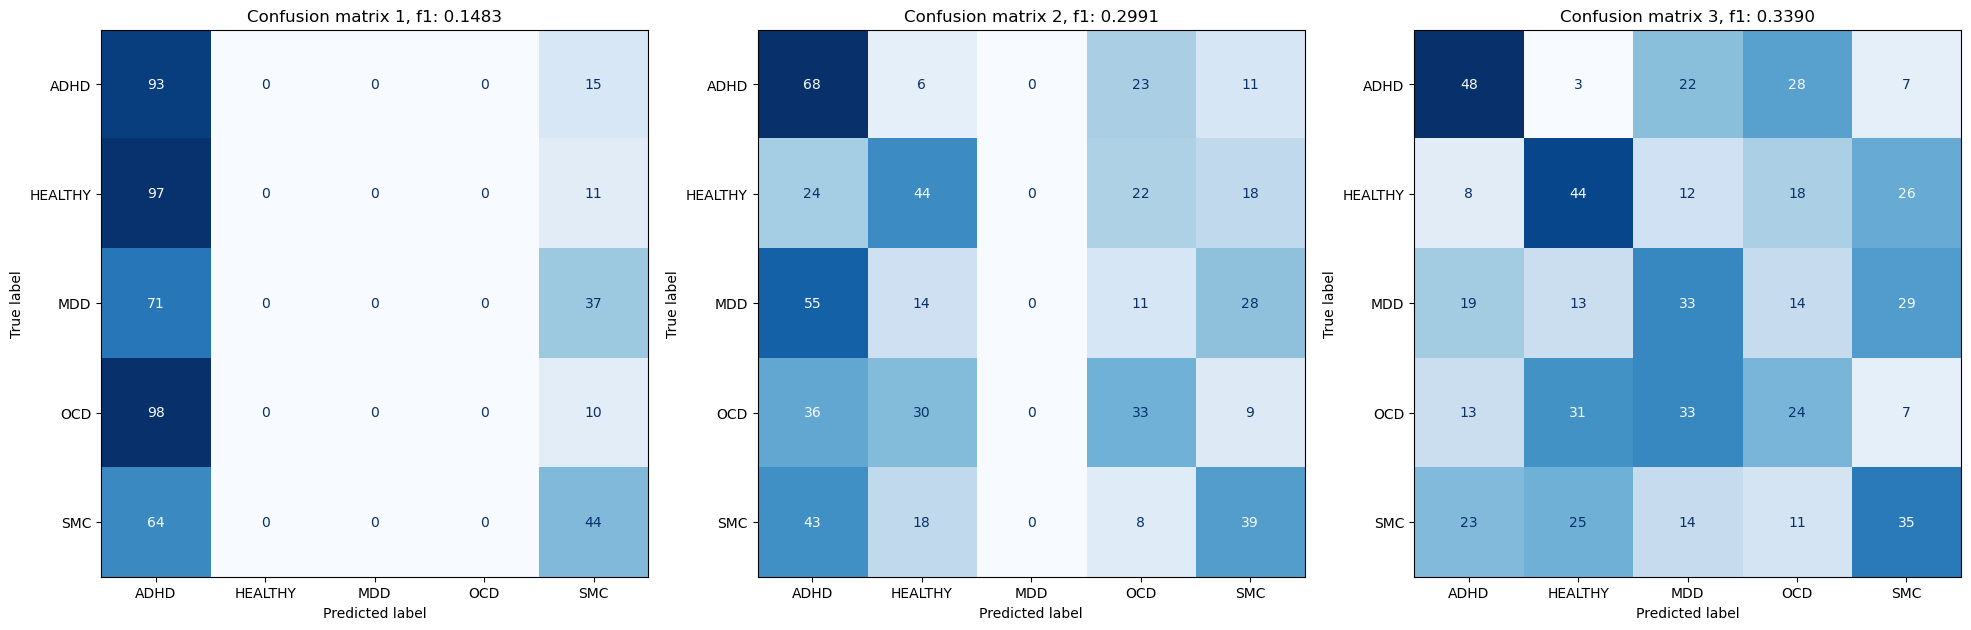

In [19]:
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar, ModelSummary
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import logging
import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

# create subplots for confusion matrices
fig, ax = plt.subplots(1, 3, figsize=(24, 16))

# list for storing f1-scores:
f1_scores = []

# iterate over the 3 best trials during tuning
for num, trial in enumerate(df_trials_w_edge_attrs.iterrows()):
    # retrieve the hyperparameters
    learning_rate = trial[1]['params_learning_rate']
    optimizer_name = trial[1]['params_optimizer']
    fc_layers = trial[1]['params_fc_layers']
    dropout = trial[1]['params_dropout']
    batch_size = trial[1]['params_batch_size']
    n_epochs = batch_size * 4
    # use best parameters from optuna
    model = graphLambda_wo_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                                drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                                drop_last=True) # , num_workers=0, persistent_workers=True


    checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                        mode='max',
                                        save_top_k=5,
                                        filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                        )


    trainer = Trainer(callbacks=[checkpoint_callback, ModelSummary(max_depth=0)],
                    accelerator='gpu',
                    max_epochs=n_epochs,
                    enable_progress_bar=False,
                    check_val_every_n_epoch=10,
                    log_every_n_steps=10,
                    deterministic=False,
                    )

    trainer.fit(model, train_loader, val_loader)

    print()
    print(f'Final evaluation #{num+1} trial:')
    # get evaluation of best model checkpoint
    trainer.validate(model, val_loader, ckpt_path='best')

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, val_loader, ckpt_path='best')
    y_pred = np.concatenate(y_pred).flatten()
    y = Y_val

    class_labels = le.inverse_transform(sorted(np.unique(y)))
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    f1_scores.append(f1_score(y, y_pred, average="macro"))

    # plot confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax[num])
    ax[num].set_title(f'Confusion matrix {num+1}, f1: {f1_score(y, y_pred, average="macro"):.4f}')
print(f'Mean f1-score 3 best trials: {np.mean(f1_scores):.4f}')
print(f'STD f1-score 3 best trials: {np.std(f1_scores):.4f}')

# 2. EO feature set

In [59]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EO'][0]
baseline_val_idxs = data_split_indices['EO'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_eo_ids for i in range(12)] # times 12 for each epoch

print(f'{len(eo_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [eo_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [eo_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[eo_y_list[i] for i in baseline_rest_idxs]
Y_val = [eo_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(eo_graph_dataset) = 2700
len(baseline_rest_idxs) = 2160, len(baseline_val_idxs) = 540, total: 2700
len(X_traintest) = 2160, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 444, total: 2160


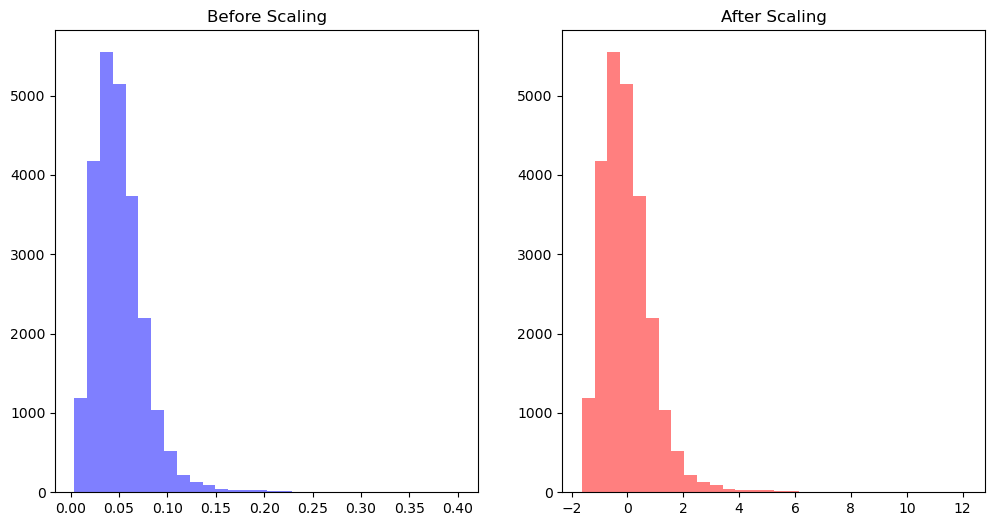

In [ ]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val])) # fit on training and validation data


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: graphLambda without edge_attr

In [60]:
# import best trials from tuning
df_trials_wo_edge_attrs = pd.read_pickle('tuning_results\eo_results_wo_edge_attrs_trials.pkl')
df_trials_wo_edge_attrs = df_trials_wo_edge_attrs.sort_values('value', ascending=False).head(3)
df_trials_wo_edge_attrs

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_fc_layers,params_learning_rate,params_optimizer,state
43,43,0.286299,2024-05-23 00:55:16.878320,2024-05-23 00:57:10.948110,0 days 00:01:54.069790,850,0.047770,4,0.001176,SGD,COMPLETE
89,89,0.286241,2024-05-23 02:42:52.596669,2024-05-23 02:44:55.679856,0 days 00:02:03.083187,510,0.075062,4,0.001842,SGD,COMPLETE
12,12,0.272355,2024-05-22 23:40:39.686177,2024-05-22 23:42:44.129774,0 days 00:02:04.443597,510,0.226099,3,0.003481,SGD,COMPLETE


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #1 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.2588820457458496     │
│         val_loss          │    1.6198196411132812     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.39      0.33      0.36       108
     HEALTHY       0.24      0.29      0.26       108
         MDD       0.24      0.19      0.21       108
         OCD       0.21      0.19      0.20       108
         SMC       0.24      0.30      0.26       108

    accuracy                           0.26       540
   macro avg       0.26      0.26      0.26       540
weighted avg       0.26      0.26      0.26       540



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #2 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.25706374645233154    │
│         val_loss          │     1.870085597038269     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.36      0.36      0.36       108
     HEALTHY       0.25      0.25      0.25       108
         MDD       0.25      0.27      0.26       108
         OCD       0.16      0.13      0.14       108
         SMC       0.26      0.29      0.27       108

    accuracy                           0.26       540
   macro avg       0.26      0.26      0.26       540
weighted avg       0.26      0.26      0.26       540



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #3 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.2513366937637329     │
│         val_loss          │    1.7245261669158936     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.36      0.42      0.39       108
     HEALTHY       0.28      0.31      0.29       108
         MDD       0.22      0.16      0.18       108
         OCD       0.15      0.15      0.15       108
         SMC       0.25      0.25      0.25       108

    accuracy                           0.26       540
   macro avg       0.25      0.26      0.25       540
weighted avg       0.25      0.26      0.25       540

Mean f1-score 3 best trials: 0.2558
STD f1-score 3 best trials: 0.0032


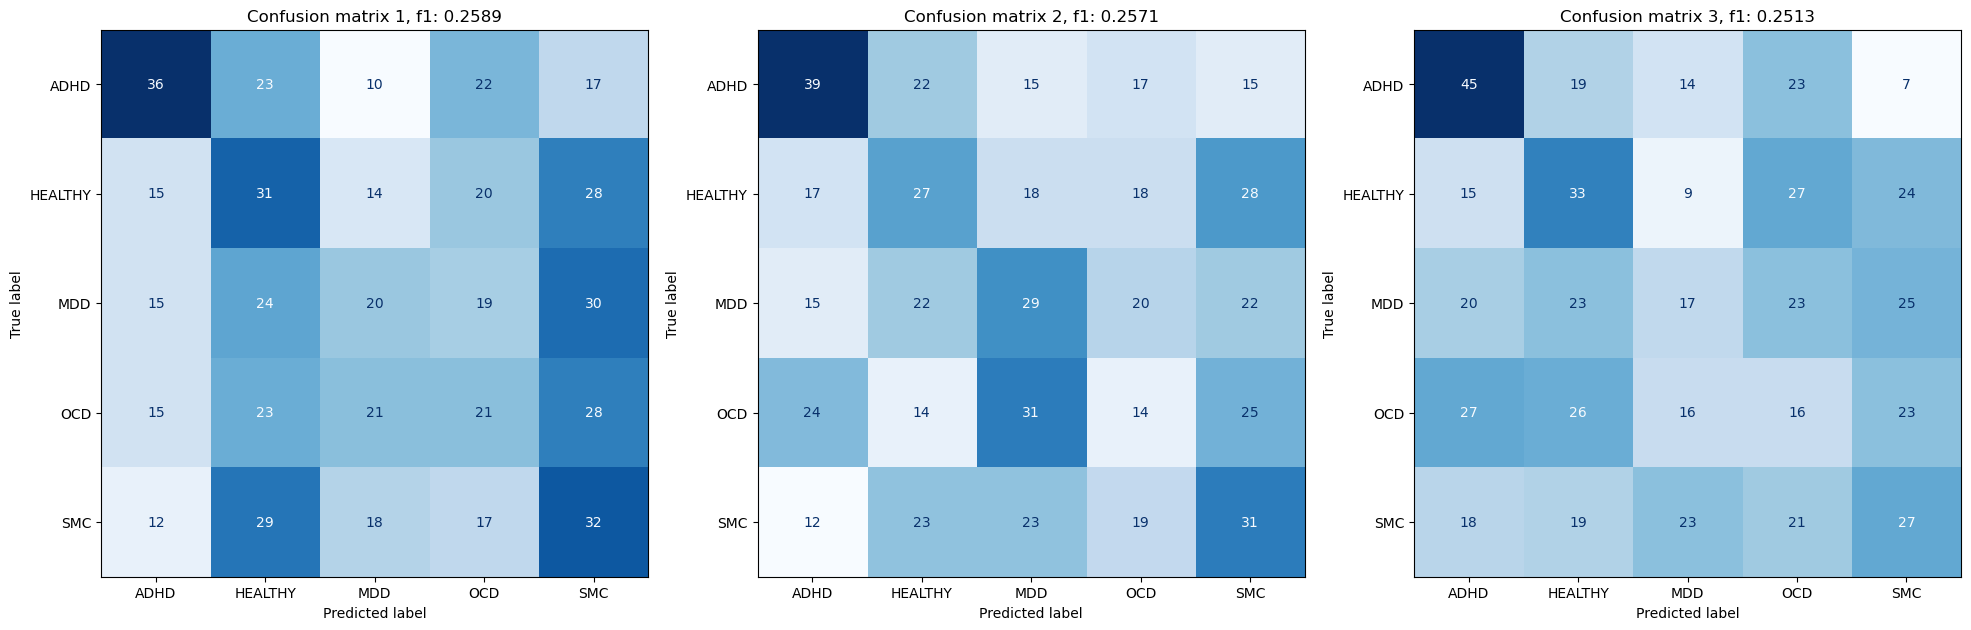

In [61]:
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar, ModelSummary
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import logging
import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

# create subplots for confusion matrices
fig, ax = plt.subplots(1, 3, figsize=(24, 16))

# list for storing f1-scores:
f1_scores = []

# iterate over the 3 best trials during tuning
for num, trial in enumerate(df_trials_wo_edge_attrs.iterrows()):
    # retrieve the hyperparameters
    learning_rate = trial[1]['params_learning_rate']
    optimizer_name = trial[1]['params_optimizer']
    fc_layers = trial[1]['params_fc_layers']
    dropout = trial[1]['params_dropout']
    batch_size = trial[1]['params_batch_size']

    # use best parameters from optuna
    model = graphLambda_wo_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                                drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                                drop_last=True) # , num_workers=0, persistent_workers=True


    checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                        mode='max',
                                        save_top_k=5,
                                        filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                        )


    trainer = Trainer(callbacks=[checkpoint_callback, ModelSummary(max_depth=0)],
                    accelerator='gpu',
                    max_epochs=800,
                    enable_progress_bar=False,
                    check_val_every_n_epoch=10,
                    log_every_n_steps=10,
                    deterministic=True,
                    )

    trainer.fit(model, train_loader, val_loader)

    print()
    print(f'Final evaluation #{num+1} trial:')
    # get evaluation of best model checkpoint
    trainer.validate(model, val_loader, ckpt_path='best')

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, val_loader, ckpt_path='best')
    y_pred = np.concatenate(y_pred).flatten()
    y = Y_val

    class_labels = le.inverse_transform(sorted(np.unique(y)))
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    f1_scores.append(f1_score(y, y_pred, average="macro"))

    # plot confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax[num])
    ax[num].set_title(f'Confusion matrix {num+1}, f1: {f1_score(y, y_pred, average="macro"):.4f}')
print(f'Mean f1-score 3 best trials: {np.mean(f1_scores):.4f}')
print(f'STD f1-score 3 best trials: {np.std(f1_scores):.4f}')

### Model: graphLambda with edge_attr

In [47]:
# import best trials from tuning
eo_df_trials_w_edge_attrs = pd.read_pickle('tuning_results\ec_results_w_edge_attrs_trials.pkl') # MISTAKE WAS MADE IN TUNING CODE, EO W EDGE ATTRS SAVED TO EC RESULTS
eo_df_trials_w_edge_attrs = eo_df_trials_w_edge_attrs.sort_values('value', ascending=False).head(3)
eo_df_trials_w_edge_attrs

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_fc_layers,params_learning_rate,params_optimizer,state
28,28,0.275476,2024-05-23 03:52:30.546909,2024-05-23 03:54:48.723853,0 days 00:02:18.176944,510,0.375902,1,0.000034,Adam,COMPLETE
52,52,0.270958,2024-05-23 04:45:43.618073,2024-05-23 04:50:13.613341,0 days 00:04:29.995268,170,0.103188,1,0.000021,Adam,COMPLETE
53,53,0.269600,2024-05-23 04:50:13.617418,2024-05-23 04:54:37.908675,0 days 00:04:24.291257,170,0.001434,1,0.000024,Adam,COMPLETE


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #1 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.24547383189201355    │
│         val_loss          │    2.2787857055664062     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.27      0.31      0.29       108
     HEALTHY       0.28      0.30      0.29       108
         MDD       0.24      0.19      0.21       108
         OCD       0.21      0.18      0.19       108
         SMC       0.23      0.28      0.25       108

    accuracy                           0.25       540
   macro avg       0.25      0.25      0.25       540
weighted avg       0.25      0.25      0.25       540


Final evaluation #2 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.2736840844154358     │
│         val_loss          │    2.7051494121551514     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.36      0.44      0.40       108
     HEALTHY       0.25      0.26      0.26       108
         MDD       0.24      0.22      0.23       108
         OCD       0.20      0.18      0.19       108
         SMC       0.30      0.29      0.30       108

    accuracy                           0.28       540
   macro avg       0.27      0.28      0.27       540
weighted avg       0.27      0.28      0.27       540


Final evaluation #3 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.27794498205184937    │
│         val_loss          │    3.2989468574523926     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.36      0.44      0.40       108
     HEALTHY       0.29      0.22      0.25       108
         MDD       0.25      0.27      0.26       108
         OCD       0.23      0.22      0.23       108
         SMC       0.25      0.25      0.25       108

    accuracy                           0.28       540
   macro avg       0.28      0.28      0.28       540
weighted avg       0.28      0.28      0.28       540

Mean f1-score 3 best trials: 0.2657
STD f1-score 3 best trials: 0.0144


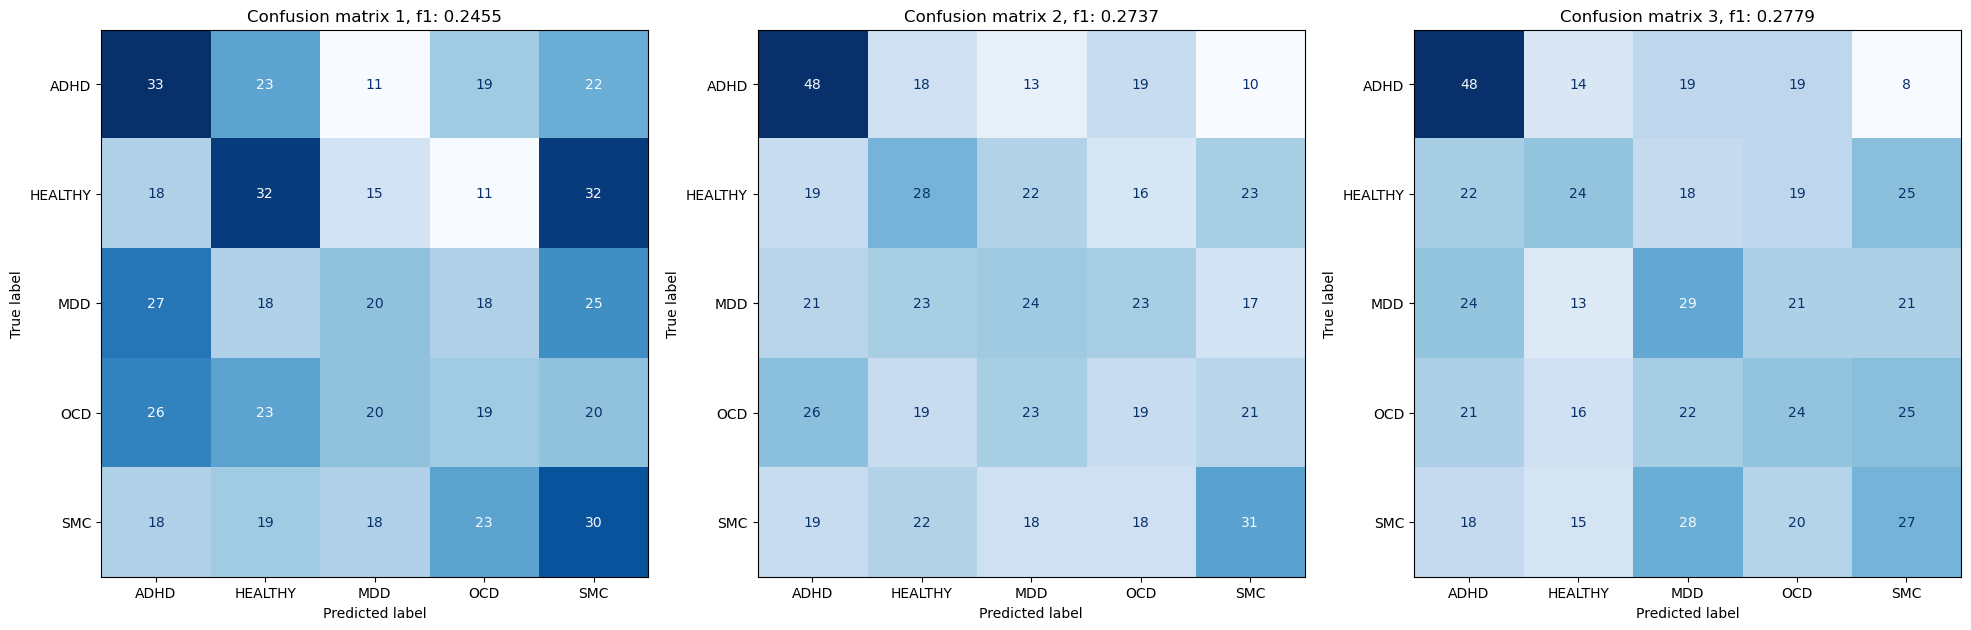

In [48]:
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar, ModelSummary
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import logging
import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

# create subplots for confusion matrices
fig, ax = plt.subplots(1, 3, figsize=(24, 16))

# list for storing f1-scores:
f1_scores = []

# iterate over the 3 best trials during tuning
for num, trial in enumerate(eo_df_trials_w_edge_attrs.iterrows()):
    # retrieve the hyperparameters
    learning_rate = trial[1]['params_learning_rate']
    optimizer_name = trial[1]['params_optimizer']
    fc_layers = trial[1]['params_fc_layers']
    dropout = trial[1]['params_dropout']
    batch_size = trial[1]['params_batch_size']

    # use best parameters from optuna
    model = graphLambda_wo_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                                drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                                drop_last=True) # , num_workers=0, persistent_workers=True


    checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                        mode='max',
                                        save_top_k=5,
                                        filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                        )


    trainer = Trainer(callbacks=[checkpoint_callback, ModelSummary(max_depth=0)],
                    accelerator='gpu',
                    max_epochs=800,
                    enable_progress_bar=False,
                    check_val_every_n_epoch=10,
                    log_every_n_steps=10,
                    deterministic=True,
                    )

    trainer.fit(model, train_loader, val_loader)

    print()
    print(f'Final evaluation #{num+1} trial:')
    # get evaluation of best model checkpoint
    trainer.validate(model, val_loader, ckpt_path='best')

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, val_loader, ckpt_path='best')
    y_pred = np.concatenate(y_pred).flatten()
    y = Y_val

    class_labels = le.inverse_transform(sorted(np.unique(y)))
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    f1_scores.append(f1_score(y, y_pred, average="macro"))

    # plot confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax[num])
    ax[num].set_title(f'Confusion matrix {num+1}, f1: {f1_score(y, y_pred, average="macro"):.4f}')
print(f'Mean f1-score 3 best trials: {np.mean(f1_scores):.4f}')
print(f'STD f1-score 3 best trials: {np.std(f1_scores):.4f}')

# 3. ratio feature set

In [49]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['ratio'][0]
baseline_val_idxs = data_split_indices['ratio'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ratio_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ratio_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ratio_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ratio_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ratio_y_list[i] for i in baseline_rest_idxs]
Y_val = [ratio_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ratio_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


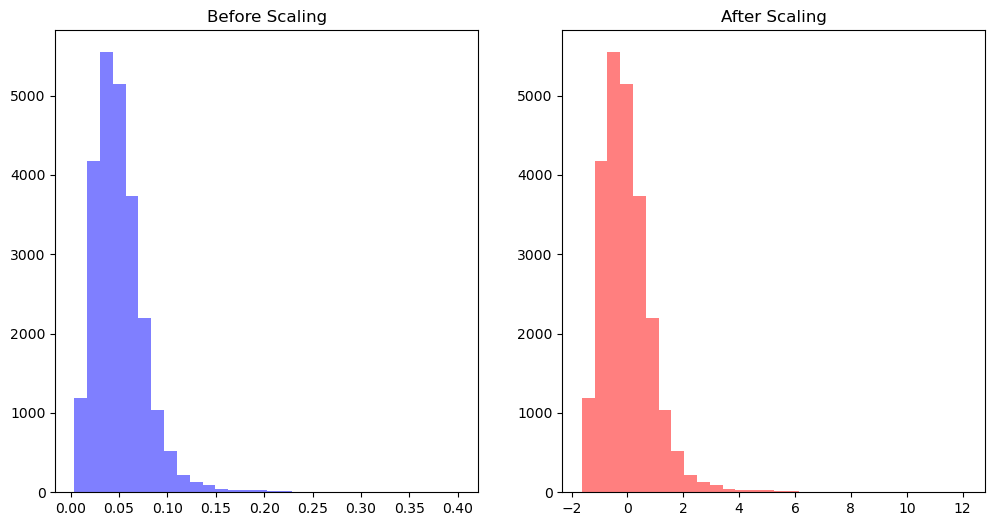

In [ ]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val])) # fit on training and validation data


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: graphLambda without edge_attr

In [50]:
# import best trials from tuning
ratio_df_trials_wo_edge_attrs = pd.read_pickle(r'tuning_results\ratio_results_wo_edge_attrs_trials.pkl') # MISTAKE WAS MADE IN TUNING CODE, ratio wo EDGE ATTRS SAVED TO EC RESULTS
ratio_df_trials_wo_edge_attrs = ratio_df_trials_wo_edge_attrs.sort_values('value', ascending=False).head(3)
ratio_df_trials_wo_edge_attrs

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_fc_layers,params_learning_rate,params_optimizer,state
72,72,0.240774,2024-05-23 08:58:24.526077,2024-05-23 09:00:02.129110,0 days 00:01:37.603033,680,0.280274,1,0.000114,RMSprop,COMPLETE
29,29,0.238696,2024-05-23 07:54:47.183915,2024-05-23 07:56:29.416631,0 days 00:01:42.232716,680,0.335566,1,0.000086,RMSprop,COMPLETE
81,81,0.234047,2024-05-23 09:17:30.668911,2024-05-23 09:19:08.698280,0 days 00:01:38.029369,680,0.376363,1,0.000064,RMSprop,COMPLETE


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #1 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.2663179337978363     │
│         val_loss          │     1.708125114440918     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.32      0.33      0.33       108
     HEALTHY       0.29      0.26      0.27       108
         MDD       0.18      0.13      0.15       108
         OCD       0.26      0.25      0.25       108
         SMC       0.28      0.39      0.33       108

    accuracy                           0.27       540
   macro avg       0.27      0.27      0.27       540
weighted avg       0.27      0.27      0.27       540



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #2 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.22466084361076355    │
│         val_loss          │    1.7846603393554688     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.19      0.27      0.22       108
     HEALTHY       0.25      0.25      0.25       108
         MDD       0.18      0.13      0.15       108
         OCD       0.23      0.22      0.23       108
         SMC       0.30      0.26      0.28       108

    accuracy                           0.23       540
   macro avg       0.23      0.23      0.22       540
weighted avg       0.23      0.23      0.22       540



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #3 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.2157697230577469     │
│         val_loss          │    1.9262303113937378     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.23      0.31      0.26       108
     HEALTHY       0.31      0.14      0.19       108
         MDD       0.24      0.26      0.25       108
         OCD       0.21      0.31      0.25       108
         SMC       0.16      0.10      0.12       108

    accuracy                           0.22       540
   macro avg       0.23      0.22      0.22       540
weighted avg       0.23      0.22      0.22       540

Mean f1-score 3 best trials: 0.2356
STD f1-score 3 best trials: 0.0220


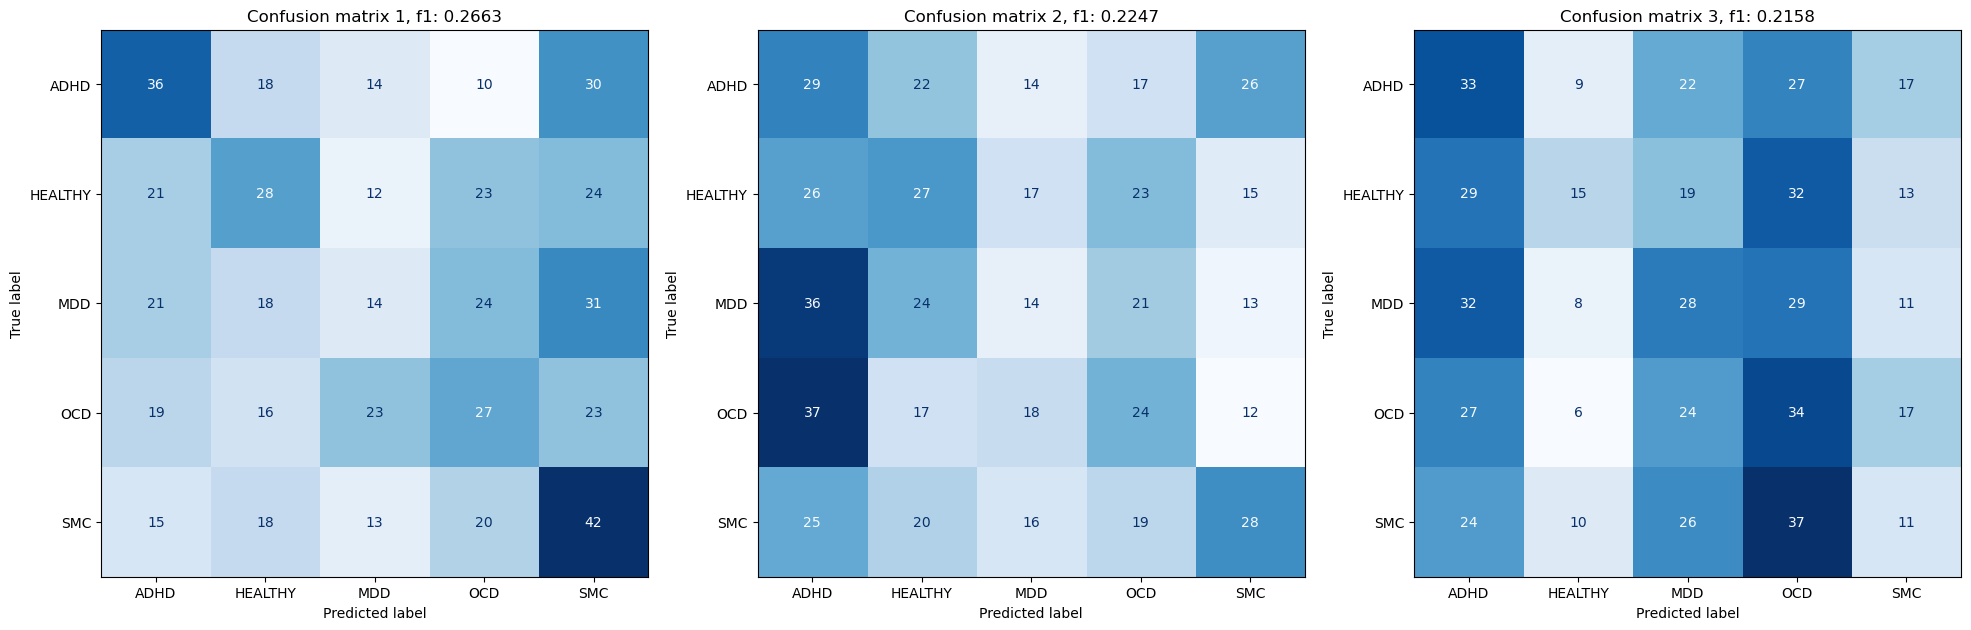

In [51]:
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar, ModelSummary
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import logging
import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

# create subplots for confusion matrices
fig, ax = plt.subplots(1, 3, figsize=(24, 16))

# list for storing f1-scores:
f1_scores = []

# iterate over the 3 best trials during tuning
for num, trial in enumerate(ratio_df_trials_wo_edge_attrs.iterrows()):
    # retrieve the hyperparameters
    learning_rate = trial[1]['params_learning_rate']
    optimizer_name = trial[1]['params_optimizer']
    fc_layers = trial[1]['params_fc_layers']
    dropout = trial[1]['params_dropout']
    batch_size = trial[1]['params_batch_size']

    # use best parameters from optuna
    model = graphLambda_wo_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                                drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                                drop_last=True) # , num_workers=0, persistent_workers=True


    checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                        mode='max',
                                        save_top_k=5,
                                        filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                        )


    trainer = Trainer(callbacks=[checkpoint_callback, ModelSummary(max_depth=0)],
                    accelerator='gpu',
                    max_epochs=800,
                    enable_progress_bar=False,
                    check_val_every_n_epoch=10,
                    log_every_n_steps=10,
                    deterministic=True,
                    )

    trainer.fit(model, train_loader, val_loader)

    print()
    print(f'Final evaluation #{num+1} trial:')
    # get evaluation of best model checkpoint
    trainer.validate(model, val_loader, ckpt_path='best')

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, val_loader, ckpt_path='best')
    y_pred = np.concatenate(y_pred).flatten()
    y = Y_val

    class_labels = le.inverse_transform(sorted(np.unique(y)))
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    f1_scores.append(f1_score(y, y_pred, average="macro"))

    # plot confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax[num])
    ax[num].set_title(f'Confusion matrix {num+1}, f1: {f1_score(y, y_pred, average="macro"):.4f}')
print(f'Mean f1-score 3 best trials: {np.mean(f1_scores):.4f}')
print(f'STD f1-score 3 best trials: {np.std(f1_scores):.4f}')

### Model: graphLambda with edge_attr

In [52]:
# import best trials from tuning
ratio_df_trials_w_edge_attrs = pd.read_pickle(r'tuning_results\ratio_results_w_edge_attrs_trials.pkl') # MISTAKE WAS MADE IN TUNING CODE, RATIO W EDGE ATTRS SAVED TO EC RESULTS
ratio_df_trials_w_edge_attrs = ratio_df_trials_w_edge_attrs.sort_values('value', ascending=False).head(3)
ratio_df_trials_w_edge_attrs

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_fc_layers,params_learning_rate,params_optimizer,state
0,0,0.258204,2024-05-23 09:45:40.969310,2024-05-23 09:47:44.991378,0 days 00:02:04.022068,680,0.162482,4,0.000014,RMSprop,COMPLETE
72,72,0.249684,2024-05-23 11:31:47.268871,2024-05-23 11:33:46.436115,0 days 00:01:59.167244,680,0.083139,4,0.000035,RMSprop,COMPLETE
77,77,0.241889,2024-05-23 11:40:32.816729,2024-05-23 11:42:45.138489,0 days 00:02:12.321760,850,0.076252,1,0.000025,Adam,COMPLETE


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #1 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.19732417166233063    │
│         val_loss          │    1.6305593252182007     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.18      0.08      0.11       108
     HEALTHY       0.24      0.33      0.28       108
         MDD       0.15      0.08      0.11       108
         OCD       0.30      0.21      0.25       108
         SMC       0.19      0.34      0.24       108

    accuracy                           0.21       540
   macro avg       0.21      0.21      0.20       540
weighted avg       0.21      0.21      0.20       540



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #2 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.2238829880952835     │
│         val_loss          │    2.3928375244140625     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.26      0.19      0.22       108
     HEALTHY       0.22      0.26      0.24       108
         MDD       0.24      0.31      0.27       108
         OCD       0.18      0.21      0.20       108
         SMC       0.25      0.17      0.20       108

    accuracy                           0.23       540
   macro avg       0.23      0.23      0.22       540
weighted avg       0.23      0.23      0.22       540



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Final evaluation #3 trial:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.22667163610458374    │
│         val_loss          │    1.9344408512115479     │
└───────────────────────────┴───────────────────────────┘

classification report:
               precision    recall  f1-score   support

        ADHD       0.28      0.21      0.24       108
     HEALTHY       0.26      0.29      0.27       108
         MDD       0.28      0.18      0.22       108
         OCD       0.18      0.30      0.23       108
         SMC       0.19      0.17      0.18       108

    accuracy                           0.23       540
   macro avg       0.24      0.23      0.23       540
weighted avg       0.24      0.23      0.23       540

Mean f1-score 3 best trials: 0.2160
STD f1-score 3 best trials: 0.0132


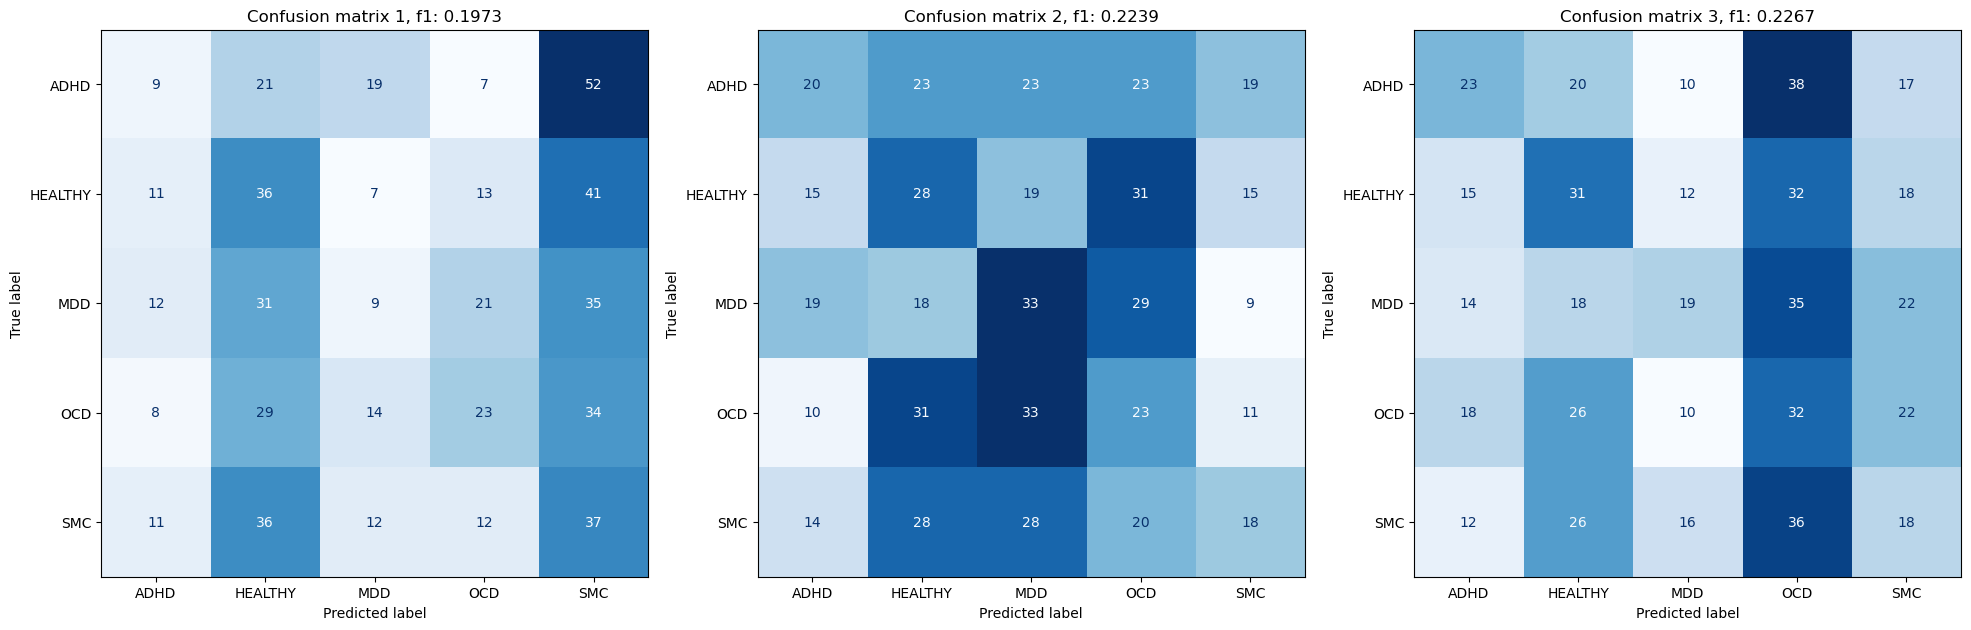

In [53]:
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar, ModelSummary
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import logging
import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

# create subplots for confusion matrices
fig, ax = plt.subplots(1, 3, figsize=(24, 16))

# list for storing f1-scores:
f1_scores = []

# iterate over the 3 best trials during tuning
for num, trial in enumerate(ratio_df_trials_w_edge_attrs.iterrows()):
    # retrieve the hyperparameters
    learning_rate = trial[1]['params_learning_rate']
    optimizer_name = trial[1]['params_optimizer']
    fc_layers = trial[1]['params_fc_layers']
    dropout = trial[1]['params_dropout']
    batch_size = trial[1]['params_batch_size']

    # use best parameters from optuna
    model = graphLambda_wo_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                                drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                                drop_last=True) # , num_workers=0, persistent_workers=True


    checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                        mode='max',
                                        save_top_k=5,
                                        filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                        )


    trainer = Trainer(callbacks=[checkpoint_callback, ModelSummary(max_depth=0)],
                    accelerator='gpu',
                    max_epochs=800,
                    enable_progress_bar=False,
                    check_val_every_n_epoch=10,
                    log_every_n_steps=10,
                    deterministic=True,
                    )

    trainer.fit(model, train_loader, val_loader)

    print()
    print(f'Final evaluation #{num+1} trial:')
    # get evaluation of best model checkpoint
    trainer.validate(model, val_loader, ckpt_path='best')

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, val_loader, ckpt_path='best')
    y_pred = np.concatenate(y_pred).flatten()
    y = Y_val

    class_labels = le.inverse_transform(sorted(np.unique(y)))
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    f1_scores.append(f1_score(y, y_pred, average="macro"))

    # plot confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax[num])
    ax[num].set_title(f'Confusion matrix {num+1}, f1: {f1_score(y, y_pred, average="macro"):.4f}')
print(f'Mean f1-score 3 best trials: {np.mean(f1_scores):.4f}')
print(f'STD f1-score 3 best trials: {np.std(f1_scores):.4f}')